In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('normalization_zscore2018.csv')

In [2]:
from imblearn.under_sampling import *
# 이상치 제거 df = df[df['123'].between(-2,2)]

In [3]:
df['상태'].value_counts()
# 3: 가입, 1: 해약, 4: 만기, 2: 행사, 0: 만기_해약

3    106467
1     84623
4     10867
2      9472
0      3665
Name: 상태, dtype: int64

In [4]:
# 만기랑 행사도 정상가입자로 볼수 있지 않을까..? 그러면 해약 vs 정상 가입 으로 분류가 가능하고 데이터 분포도 얼추 비슷함..
# 가입: 0  / 해약 : 1
def labeling(status):
    if status == 0:
        return 1
    elif status == 1: # = 1
        return 1
    elif status == 2: # = 2
        return 0
    elif status == 3: # = 3
        return 0
    else: # 만기 = 4
        return 0

In [5]:
df['상태'] = df['상태'].apply(lambda x : labeling(x))

In [6]:
df['상태'].value_counts()

0    126806
1     88288
Name: 상태, dtype: int64

In [7]:
# 랜덤 언더 샘플링으로 두 Label 갯수를 똑같이 맞춰줌
df0 = df[df['상태']==0].sample(n=88288)
df1 = df[df['상태']==1]

In [8]:
data = pd.concat([df0, df1])

In [9]:
data['상태'].value_counts()

1    88288
0    88288
Name: 상태, dtype: int64

In [10]:
data.head(5)

,이름번호,성별,나이,진행률,상품금액,잔여금액,연체횟수,가입기간,상태
205546,전세환780407,1,-0.953312,0.004000,1.486270,1.122658,-0.634846,-0.853229,0
192772,박미자661201,1,-0.109620,0.007692,0.655880,0.729600,-0.601494,-0.842853,0
153788,전금순740608,1,-0.672081,0.092308,0.655880,0.517656,-0.634846,-0.513922,0
214978,박민숙541219,1,0.734072,1.000000,-0.589706,-1.755918,-0.634846,2.274209,0
165633,박신영990503,1,-2.429774,0.017949,0.655880,0.703909,-0.634846,-0.670605,0


In [11]:
data.to_csv('under_sampling.csv')

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = data[['성별', '나이', '진행률', '상품금액', '잔여금액', '연체횟수', '가입기간']]
rf.data = rf.values.tolist()
rf.target = data[['상태']]
rf.feature_names=['sex','age','process_rate','price','remaining_price','overdue_num','period']
rf.target_names=['contract','cancellation']
rf.head(3)

,성별,나이,진행률,상품금액,잔여금액,연체횟수,가입기간
205546,1,-0.953312,0.004000,1.48627,1.122658,-0.634846,-0.853229
192772,1,-0.109620,0.007692,0.65588,0.729600,-0.601494,-0.842853
153788,1,-0.672081,0.092308,0.65588,0.517656,-0.634846,-0.513922


In [13]:
X_train , X_test , y_train , y_test = train_test_split(rf.data, rf.target, test_size=0.3,  random_state=33)
rnd_clf = RandomForestClassifier(n_estimators=250, max_depth=9 , n_jobs=-1, random_state=0)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

accuracy = accuracy_score(y_test , y_pred_rf)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9657


In [14]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix
from sklearn.metrics import f1_score 

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred,average='macro')
    recall = recall_score(y_test , pred, average='macro')
    # F1 스코어 추가
    f1 = f1_score(y_test,pred, average='macro')
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

In [15]:
get_clf_eval(y_test,y_pred_rf )
y_pred_rf 

오차 행렬
[[25013  1476]
 [  343 26141]]
정확도: 0.9657, 정밀도: 0.9665, 재현율: 0.9657, F1:0.9656


array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

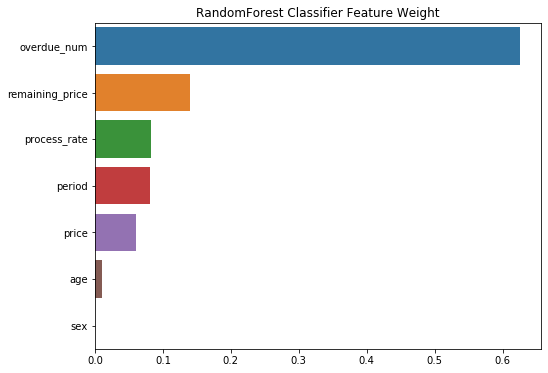

In [16]:
import seaborn as sns

ftr_importances_values = rnd_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=rf.feature_names)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:7]

plt.figure(figsize=(8,6))
plt.title('RandomForest Classifier Feature Weight')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()